In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [3]:
from mmctools.plotting import plot_timeheight, plot_profile, plot_timehistory_at_height
import assessment.studies.coupling_comparison.helpers as helper

# Generate hybrid WRF / TTU-tower time-height profiles
for use as microscale input

Ideas:
- "nudge" the WRF data toward the tower data near the ground
- maintain the same gradient at the edge and outside of the boundary layer

In [4]:
starttime = '2013-11-08'
endtime = '2013-11-10'

In [5]:
# expect this notebook to be in assessment/studies/coupling_comparison/preprocessing/internal
swiftdir = os.path.join('..','..','..','..','datasets','SWiFT','data')
wrfdata = os.path.join(swiftdir,'WRF_20131108-09.nc')
towerdata = os.path.join(swiftdir,'TTU_tilt_corrected_20131108-09_10min.csv')

In [6]:
hybrid_output = os.path.join('data','WRF_TTU_hybrid_10min.csv')

## 1. load data

### 10-min TTU tower data
from `datasets/SWiFT/process_TTU_tower.ipynb`

In [7]:
%time tower = helper.load_tower_reference_data(towerdata)

CPU times: user 26.3 ms, sys: 5.91 ms, total: 32.2 ms
Wall time: 36.6 ms


In [8]:
tower.index.levels[0]

DatetimeIndex(['2013-11-08 00:00:00', '2013-11-08 00:10:00',
               '2013-11-08 00:20:00', '2013-11-08 00:30:00',
               '2013-11-08 00:40:00', '2013-11-08 00:50:00',
               '2013-11-08 01:00:00', '2013-11-08 01:10:00',
               '2013-11-08 01:20:00', '2013-11-08 01:30:00',
               ...
               '2013-11-09 22:20:00', '2013-11-09 22:30:00',
               '2013-11-09 22:40:00', '2013-11-09 22:50:00',
               '2013-11-09 23:00:00', '2013-11-09 23:10:00',
               '2013-11-09 23:20:00', '2013-11-09 23:30:00',
               '2013-11-09 23:40:00', '2013-11-09 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=288, freq=None)

In [9]:
tower_heights = tower.index.levels[1]
tower_heights

Float64Index([0.9, 2.4, 4.0, 10.1, 16.8, 47.3, 74.7, 116.5, 158.2, 200.0], dtype='float64', name='height')

In [10]:
tower.head()

RH        T          Ts           p       theta  \
datetime   height                                                        
2013-11-08 0.9     26.186  284.794  289.410000  908.547754  292.713920   
           2.4     25.810  284.932  290.979994  908.723508  292.839558   
           4.0     25.380  285.166  287.520000  908.215548  293.126923   
           10.1    25.264  285.298  287.250000  907.611414  293.318423   
           16.8    24.934  285.414  287.610000  907.307654  293.465778   

                       thetas         u         v         w      wspd  ...  \
datetime   height                                                      ...   
2013-11-08 0.9     297.458288 -0.138929  2.637817  0.074016  2.641473  ...   
           2.4     299.055399 -0.601111  2.783204  0.487330  2.847378  ...   
           4.0     295.546639  0.416792  4.043940  0.295800  4.065362  ...   
           10.1    295.325299 -0.276479  5.227110 -0.418065  5.234417  ...   
           16.8    295.723729  0.034364  5.908367 -0.173836  5.908467  ...   

                         vv        ww   uv   vw   uw   Tw  thetaw   u*  \
datetime   height                                                        
2013-11-08 0.9     0.015000  0.008343  0.0  0.0  0.0  0.0     0.0  0.0   
           2.4     0.165325  0.078520  0.0  0.0  0.0  0.0     0.0  0.0   
           4.0     0.269958  0.003119  0.0  0.0  0.0  0.0     0.0  0.0   
           10.1    0.027879  0.221537  0.0  0.0  0.0  0.0     0.0  0.0   
           16.8    0.054370  0.019302  0.0  0.0  0.0  0.0     0.0  0.0   

                        TKE        TI  
datetime   height                      
2013-11-08 0.9     0.012876  0.048324  
           2.4     0.289067  0.126433  
           4.0     0.141290  0.117591  
           10.1    0.127415  0.032939  
           16.8    0.041629  0.040432  

[5 rows x 22 columns]

### WRF reference data

In [11]:
wrf = helper.load_wrf_reference_data(wrfdata)
wrf.index.levels[0].name = 'datetime'

In [12]:
# trim WRF data
print('before',len(wrf), wrf.index.levels[0][0], wrf.index.levels[0][-1])
wrf = wrf.loc[(slice(tower.index.levels[0][0],tower.index.levels[0][-1]),slice(None)),:]
# Note: the original levels from the multiindex remain at this point, so let's reset them
wrf = wrf.reset_index().set_index(['datetime','height'])
print('after',len(wrf), wrf.index.levels[0][0], wrf.index.levels[0][-1])

before 144761 2013-11-08 00:00:00 2013-11-10 12:00:00
after 115488 2013-11-08 00:00:00 2013-11-09 23:50:00


In [13]:
# make sure our timestamps are synchronized, so no nasty surprises later
assert np.all(wrf.index.levels[0] == tower.index.levels[0])

In [14]:
wrf_heights = wrf.index.levels[1]
wrf_heights

Float64Index([   0.0,    5.0,   10.0,   15.0,   20.0,   25.0,   30.0,   35.0,
                40.0,   45.0,
              ...
              1955.0, 1960.0, 1965.0, 1970.0, 1975.0, 1980.0, 1985.0, 1990.0,
              1995.0, 2000.0],
             dtype='float64', name='height', length=401)

In [15]:
# expect the WRF reference data to have constant vertical spacing
dz_wrf = wrf_heights[1] - wrf_heights[0]
assert np.all(np.diff(wrf_heights) == dz_wrf)

In [16]:
wrf.head()

U10      V10          T2         TSK      u*  \
datetime   height                                                      
2013-11-08 0.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           5.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           10.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           15.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           20.0    0.476012  4.92231  284.730592  282.509581  0.0001   

                           PSFC  HFX   LH  MUU  MUV  ...  RV_TEND_PGF  \
datetime   height                                    ...                
2013-11-08 0.0     91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           5.0     91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           10.0    91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           15.0    91081.063181  0.0  0.0  0.0  0.0  ...          NaN   
           20.0    91081.063181  0.0  0.0  0.0  0.0  ...          NaN   

                   RV_TEND_COR  RV_TEND_PHYS  T_TEND_ADV   wt   L0  \
datetime   height                                                    
2013-11-08 0.0             NaN           NaN         NaN  0.0 -inf   
           5.0             NaN           NaN         NaN  0.0 -inf   
           10.0            NaN           NaN         NaN  0.0 -inf   
           15.0            NaN           NaN         NaN  0.0 -inf   
           20.0            NaN           NaN         NaN  0.0 -inf   

                      thetaSK      theta2      wspd        wdir  
datetime   height                                                
2013-11-08 0.0     290.149435  292.430509  0.000000  180.000000  
           5.0     290.149435  292.430509  5.078049  185.549135  
           10.0    290.149435  292.430509  5.212031  185.580797  
           15.0    290.149435  292.430509  5.346031  185.610835  
           20.0    290.149435  292.430509  5.420783  185.593014  

[5 rows x 32 columns]

### initial plots

In [17]:
plot_height = 500.
plot_range = (275,305)

/Users/equon/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


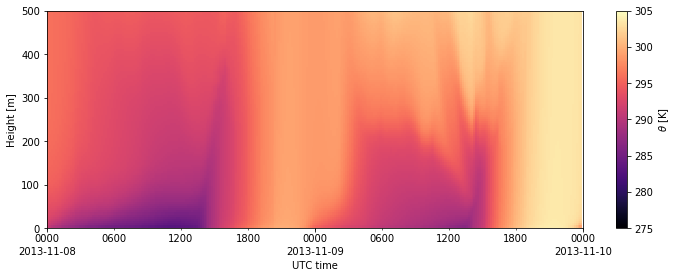

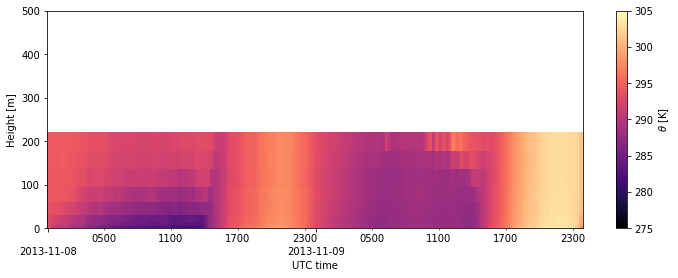

In [18]:
fig,ax,cbars = plot_timeheight(wrf,
                               fields='theta',
                               fieldlimits={'theta':plot_range},
                               timelimits=(starttime,endtime),
                               heightlimits=(0,plot_height),
                               cmap='magma',
                              )
fig,ax,cbars = plot_timeheight(tower,
                               fields='theta',
                               fieldlimits={'theta':(275,305)},
                               heightlimits=(0,plot_height),
                               cmap='magma',
                              )

### match WRF data to tower heights
at lower levels

Note: this changes the `wrf` dataframe

In [19]:
unstacked = wrf.unstack(level=0)
for hgt in tower_heights:
    if hgt not in wrf_heights:
        print('interpolating to z=',hgt)
        unstacked.loc[hgt] = interp1d(unstacked.index, unstacked, axis=0)(hgt)

interpolating to z= 0.9
interpolating to z= 2.4
interpolating to z= 4.0
interpolating to z= 10.1
interpolating to z= 16.8
interpolating to z= 47.3


/Users/equon/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


interpolating to z= 74.7
interpolating to z= 116.5
interpolating to z= 158.2


In [20]:
# only keep lower heights that coincide with tower locations
unstacked = pd.concat([
    unstacked.loc[tower_heights],
    unstacked.loc[unstacked.index > tower_heights[-1]]
])

In [21]:
wrf = unstacked.stack().reorder_levels(order=['datetime','height']).sort_index()

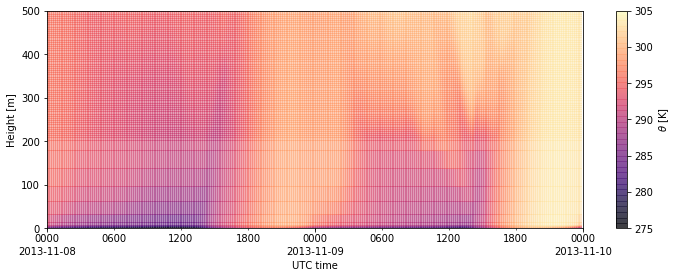

In [22]:
# sanity check WRF interpolated data
fig,ax,cbars = plot_timeheight(wrf,
                               fields='theta',
                               fieldlimits={'theta':plot_range},
                               timelimits=(starttime,endtime),
                               heightlimits=(0,plot_height),
                               cmap='magma',
                               alpha=0.5, # to hint at mesh edges
                              )

## 2. check temperature gradients

In [23]:
def calc_vertical_gradient(df):
    """Calculate backward differences"""
    unstacked = df.unstack(level=0)
    # note: pd.DataFrame.diff returns dataframe with first row (for axis=0) set to nans
    deltaf = unstacked.diff(axis=0)
    # calculate dz (note: np.diff returns an array with one fewer element)
    deltaz = np.diff(unstacked.index.values)
    assert np.all(deltaz > 0) # make sure array was sorted
    deltaz = np.insert(deltaz,0,np.nan)
    # now return the finite difference
    return deltaf.divide(deltaz, axis='rows').stack().reorder_levels(order=['datetime','height']).sort_index()

In [24]:
wrf_grad = calc_vertical_gradient(wrf)

In [25]:
tower_grad = calc_vertical_gradient(tower)

### compare initial datasets
at select tower heights

In [26]:
tower_heights

Float64Index([0.9, 2.4, 4.0, 10.1, 16.8, 47.3, 74.7, 116.5, 158.2, 200.0], dtype='float64', name='height')

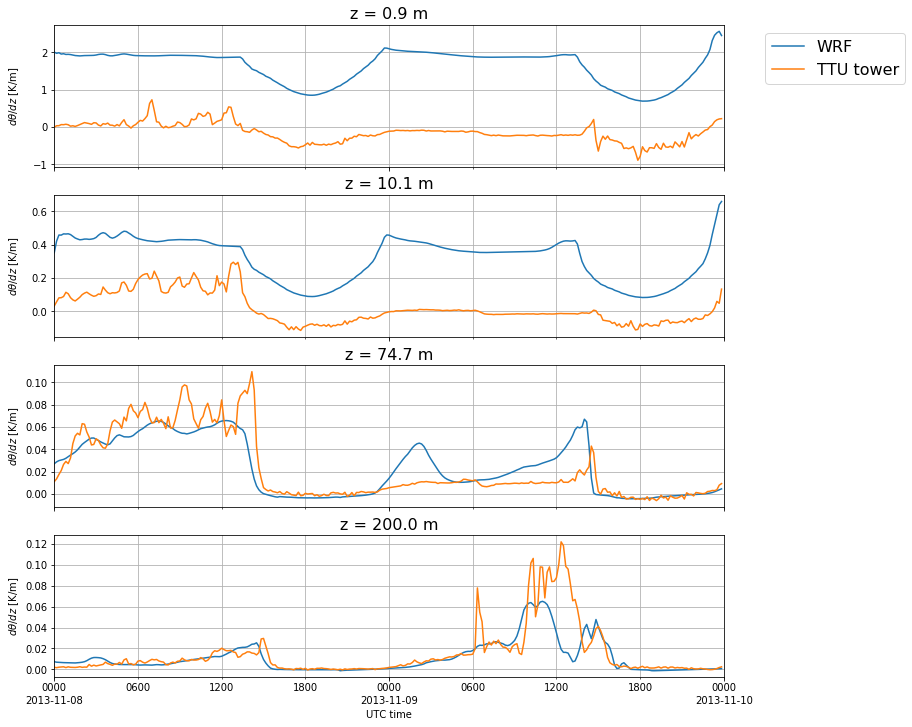

In [27]:
fig,ax = plot_timehistory_at_height({'WRF':wrf_grad, 'TTU tower':tower_grad},
                                    fields='theta', fieldlabels={'theta':r'$d\theta/dz$ [K/m]'},
                                    heights=[0.9, 10.1, 74.7, 200],
                                    stack_by_datasets=True,
                                    timelimits=(starttime,endtime))

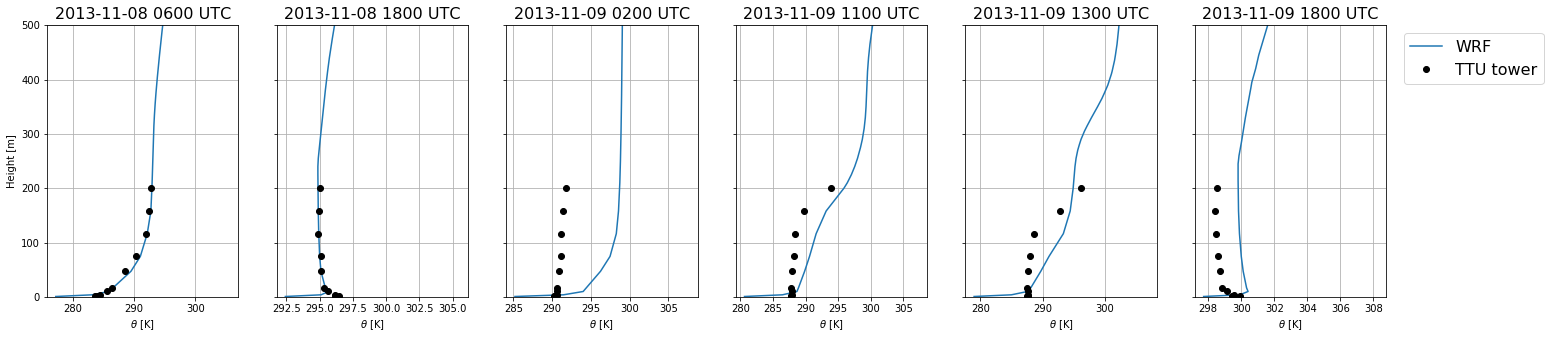

In [28]:
tower_style = dict(linestyle='none',marker='o',color='k')
fig,ax = plot_profile({'WRF':wrf, 'TTU tower':tower},
                      fields='theta',
                      times=('2013-11-08 06:00',
                             '2013-11-08 18:00',
                             '2013-11-09 02:00',
                             '2013-11-09 11:00',
                             '2013-11-09 13:00',
                             '2013-11-09 18:00',),
                      datasetkwargs={'TTU tower':tower_style},
                      heightlimits=(0,plot_height),
                      stack_by_datasets=True,
                     )
fig.savefig('figures/Tprofiles_WRF.png')

## 2. create new hybrid dataset
Need to calculate:
- $\Delta\theta(t)$ : doesn't affect gradients aloft - does this need to be smooth?
- $\Delta\theta_{blend}(t,z)$ : to transition between tower and original WRF data, only applied up to `tower_heights[-1] + gradient_transition_thickness`

In [29]:
# the region over which the temperature gradient is blended from the top of the tower to 
gradient_transition_thickness = 100.

### calculations

In [30]:
hybrid = wrf['theta'].copy()
hybrid[:] = np.nan

In [31]:
# set tower values
hybrid.loc[(slice(None),tower_heights)] = tower['theta']

In [32]:
# handle situation in which the specified transition thickness doesn't result in a point that's exactly on the WRF grid
ztmp = tower_heights[-1] + gradient_transition_thickness
transition_top = wrf_heights[wrf_heights >= ztmp][0]
print(ztmp,transition_top)

300.0 300.0


In [33]:
# calculate temperature gradient at bottom/top of the transition region
transition_bottom = tower_heights[-1]
transition_region = wrf_heights[(wrf_heights >= transition_bottom) & (wrf_heights <= transition_top)]
dTdz_bottom = tower_grad.loc[(slice(None),transition_bottom),'theta']
dTdz_top = wrf_grad.loc[(slice(None),transition_top),'theta']

In [34]:
transition_region

Float64Index([200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0,
              245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0,
              290.0, 295.0, 300.0],
             dtype='float64', name='height')

In [35]:
# created time-height series of blended gradients
blended_dTdz = pd.concat([dTdz_bottom, dTdz_top]).sort_index().reindex_like(wrf)
blended_dTdz.head(35)

datetime    height
2013-11-08  0.9            NaN
            2.4            NaN
            4.0            NaN
            10.1           NaN
            16.8           NaN
            47.3           NaN
            74.7           NaN
            116.5          NaN
            158.2          NaN
            200.0     0.001812
            205.0          NaN
            210.0          NaN
            215.0          NaN
            220.0          NaN
            225.0          NaN
            230.0          NaN
            235.0          NaN
            240.0          NaN
            245.0          NaN
            250.0          NaN
            255.0          NaN
            260.0          NaN
            265.0          NaN
            270.0          NaN
            275.0          NaN
            280.0          NaN
            285.0          NaN
            290.0          NaN
            295.0          NaN
            300.0     0.002752
            305.0          NaN
            310.0   

In [36]:
dTdz_bottom.head()

datetime             height
2013-11-08 00:00:00  200.0     0.001812
2013-11-08 00:10:00  200.0     0.001443
2013-11-08 00:20:00  200.0     0.001909
2013-11-08 00:30:00  200.0     0.002121
2013-11-08 00:40:00  200.0     0.002290
Name: theta, dtype: float64

In [37]:
# interpolate to all wrf levels within transition region
# - note: this interpolates on the multiindex and assumes that the heights are equally spaced
# - the more robust way is to unstack and then interpolate with method='index'
blended_dTdz = blended_dTdz.interpolate().loc[(slice(None), transition_region[1:])]
blended_dTdz.head(21)

datetime             height
2013-11-08 00:00:00  205.0     0.001859
                     210.0     0.001906
                     215.0     0.001953
                     220.0     0.002000
                     225.0     0.002047
                     230.0     0.002094
                     235.0     0.002141
                     240.0     0.002188
                     245.0     0.002235
                     250.0     0.002282
                     255.0     0.002329
                     260.0     0.002376
                     265.0     0.002423
                     270.0     0.002470
                     275.0     0.002517
                     280.0     0.002564
                     285.0     0.002611
                     290.0     0.002658
                     295.0     0.002705
                     300.0     0.002752
2013-11-08 00:10:00  205.0     0.001384
Name: theta, dtype: float64

In [38]:
Tbottom = tower['theta'].xs(tower_heights[-1],level='height')
Tbelow = tower['theta'].xs(tower_heights[-2],level='height') # used for following sanity check
assert np.all((Tbottom - Tbelow)/np.diff(tower_heights[-2:]) == dTdz_bottom.values)

In [39]:
# calculate _change_ in termperature, within transition region, using blended temperature gradient
blended_dT = dz_wrf * blended_dTdz.unstack().cumsum(axis=1).stack()

In [40]:
# now, update transition region temperature
hybrid.loc[(slice(None), transition_region[1:])] = Tbottom + blended_dT

In [41]:
# determine offset for remainder of WRF domain aloft
Toffset = hybrid.loc[(slice(None), transition_top)] \
           - wrf.loc[(slice(None), transition_top),'theta']
Toffset = Toffset.xs(transition_top,level='height') # drop extra index
Toffset.head()

datetime
2013-11-08 00:00:00   -1.411244
2013-11-08 00:10:00   -1.413248
2013-11-08 00:20:00   -1.368989
2013-11-08 00:30:00   -1.299030
2013-11-08 00:40:00   -1.214599
Name: theta, dtype: float64

In [42]:
# finally, fill in the upper WRF levels
hybrid.loc[(slice(None), slice(transition_top,None))] = \
   wrf.loc[(slice(None), slice(transition_top,None)),'theta'] + Toffset

In [43]:
hybrid_grad = calc_vertical_gradient(hybrid)

### check new data

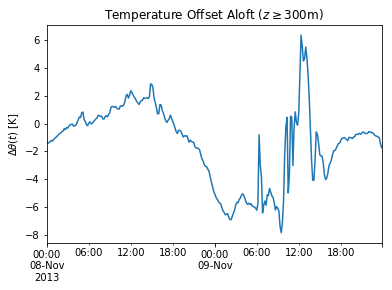

In [44]:
fig,ax = plt.subplots()
Toffset.plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\theta(t)$ [K]')
ax.set_title(r'Temperature Offset Aloft ($z \geq {:g}$m)'.format(transition_top))
fig.savefig('figures/Toffset_hybrid{:g}.png'.format(gradient_transition_thickness),
            bbox_inches='tight')

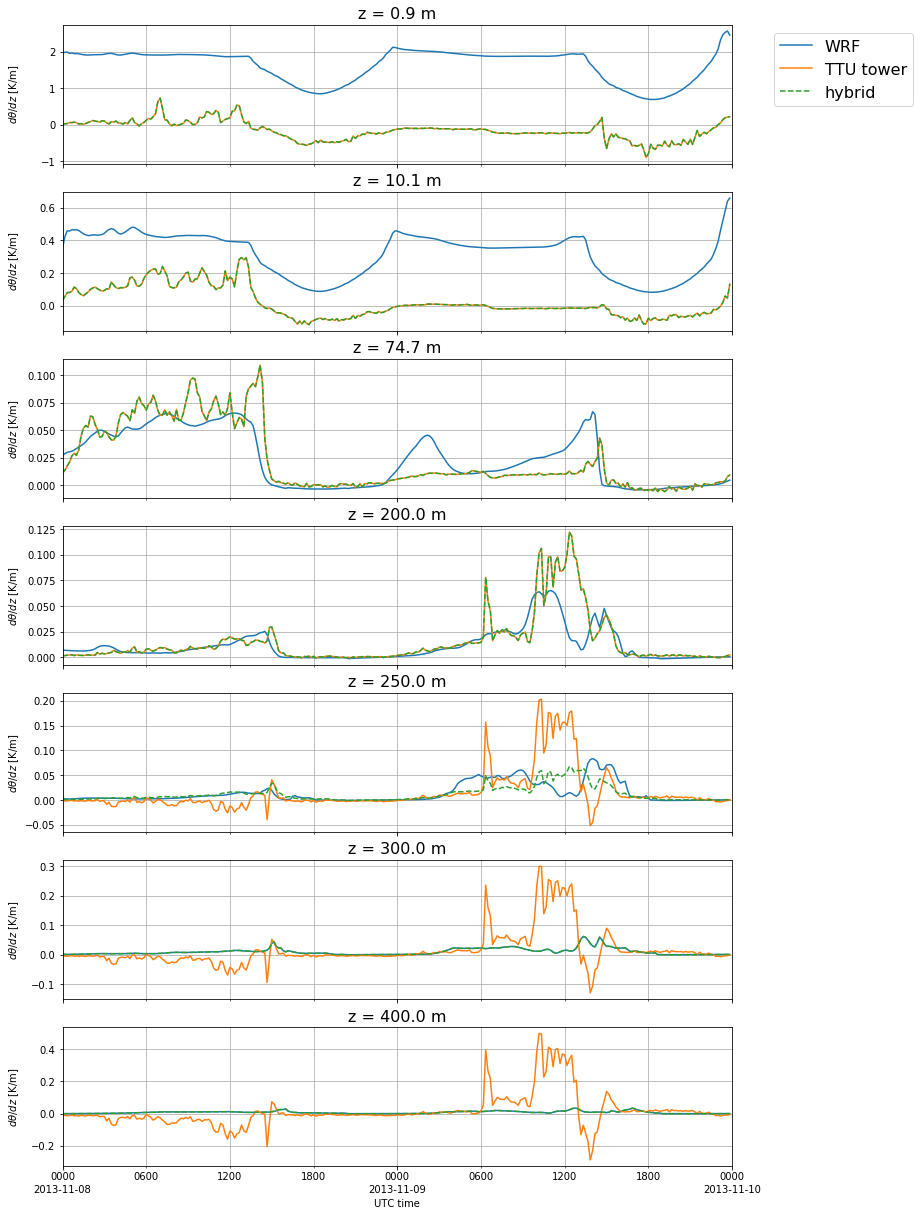

In [45]:
fig,ax = plot_timehistory_at_height({'WRF':wrf_grad, 'TTU tower':tower_grad, 'hybrid':hybrid_grad},
                                    fields='theta', fieldlabels={'theta':r'$d\theta/dz$ [K/m]'},
                                    heights=[0.9, 10.1, 74.7, 200, 250, 300, 400],
                                    datasetkwargs={'hybrid':dict(linestyle='--')},
                                    stack_by_datasets=True,
                                    timelimits=(starttime,endtime))

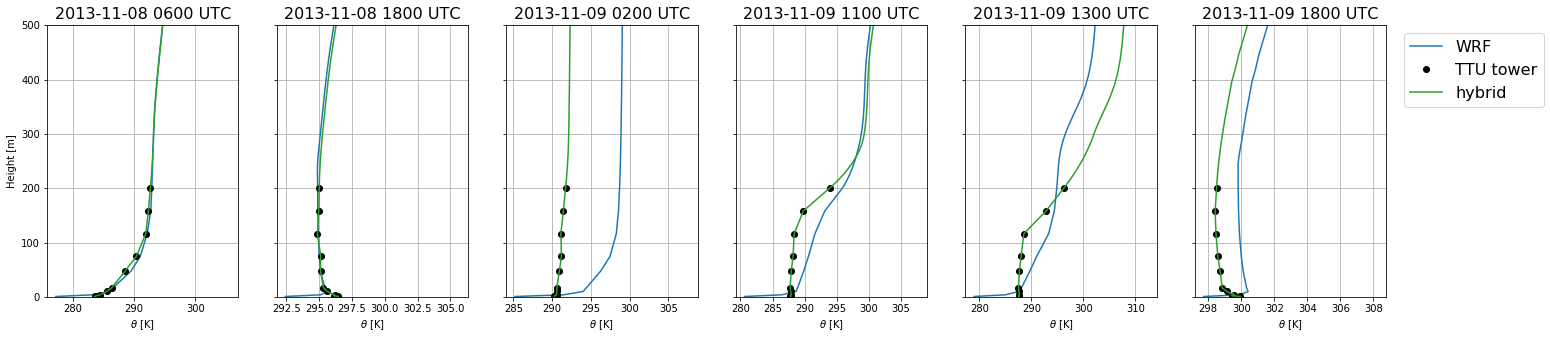

In [46]:
tower_style = dict(linestyle='none',marker='o',color='k')
fig,ax = plot_profile({'WRF':wrf, 'TTU tower':tower, 'hybrid':hybrid},
                      fields='theta',
                      times=('2013-11-08 06:00',
                             '2013-11-08 18:00',
                             '2013-11-09 02:00',
                             '2013-11-09 11:00',
                             '2013-11-09 13:00',
                             '2013-11-09 18:00',),
                      datasetkwargs={'TTU tower':tower_style},
                      heightlimits=(0,plot_height),
                      stack_by_datasets=True,
                     )
fig.savefig('figures/Tprofiles_hybrid{:g}.png'.format(gradient_transition_thickness))

## compare driving data

Text(0.5, 1.0, 'hybrid driving data')

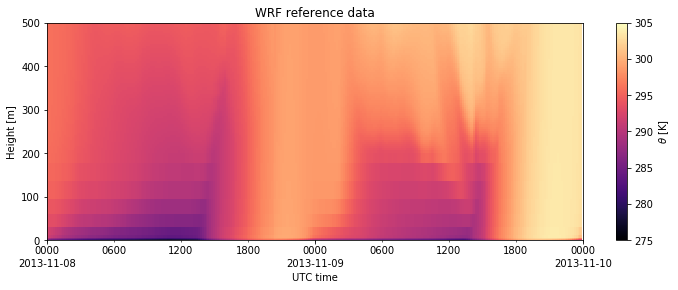

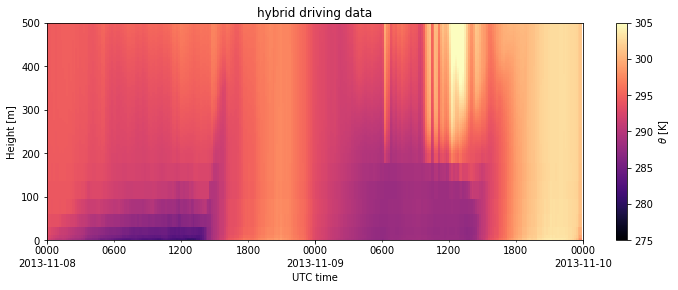

In [47]:
fig,ax,cbars = plot_timeheight(wrf,
                               fields='theta',
                               fieldlimits={'theta':plot_range},
                               timelimits=(starttime,endtime),
                               heightlimits=(0,plot_height),
                               cmap='magma',
                              )
ax.set_title('WRF reference data')

fig,ax,cbars = plot_timeheight(hybrid,
                               fields='theta',
                               fieldlimits={'theta':plot_range},
                               timelimits=(starttime,endtime),
                               heightlimits=(0,plot_height),
                               cmap='magma',
                              )
ax.set_title('hybrid driving data')

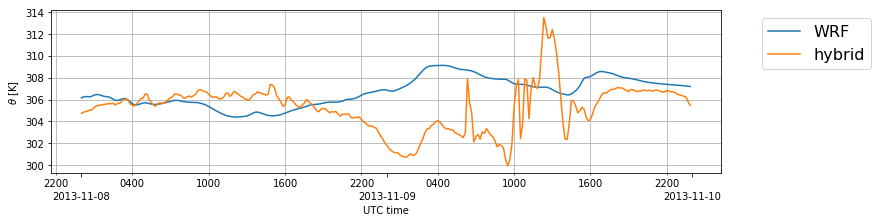

In [48]:
fig,ax = plot_timehistory_at_height({'WRF':wrf,'hybrid':hybrid},
                                    heights=2000.,
                                    fields='theta')
fig.savefig('figures/Ttop_hybrid{:g}.png'.format(gradient_transition_thickness))

In [49]:
wrf_hybrid = wrf.copy()
wrf_hybrid['theta'] = hybrid
wrf_hybrid.to_csv(hybrid_output)